<a id="top"></a>
# Table of contents

#### 1. [Package instalation (optional)](#1)
#### 2. [Data loading](#2)
#### 3. [Feature Engineering](#3)
- ##### 3.1. [Outline](#3_1)
- ##### 3.2. [Tokenization](#3_2)
- ##### 3.3. [Basic word- and sentence-level metrics](#3_3)
- ##### 3.4. [Subjectivity and Polarity metrics](#3_4)
- ##### 3.5. [Cosine subjectivity between prompt_text and summary](#3_5)
- ##### 3.6. [Readability score](#3_6)
- ##### 3.7. [Misspelling frequency](#3_7)
- ##### 3.8. [Topic overlap](#3_8)
- ##### 3.9. [N-gram overlap](#3_9)
- ##### 3.10. [Entity overlap](#3_10)
- ##### 3.11. [Transition words frequency ratio](#3_11)

<a id="1"></a>
## 1. Package installation

In [1]:
#! pip install transformers sentence-transformers
#! pip install word2number
! pip install spacy

<a id="2"></a>
## 2. Data loading

In [2]:
import pandas as pd
from IPython.display import display

In [3]:
summaries_train_df = pd.read_csv('../data/summaries_train.csv')
prompts_train_df = pd.read_csv('../data/prompts_train.csv')

In [4]:
#join the two data frames based on a unique key and drop unnecessary columns
joined_df = pd.merge(prompts_train_df, summaries_train_df, on = 'prompt_id')
joined_df.drop(['prompt_id', 'student_id'], axis = 1, inplace = True)

#rename 'text' column to 'summary'
joined_df.rename(columns = {'text' : 'summary'}, inplace=True)

joined_df.head(3)

,prompt_question,prompt_title,prompt_text,summary,content,wording
0,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415
1,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,The three elements of an ideal tragedy are: H...,-0.970237,-0.417058
2,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,Aristotle states that an ideal tragedy should ...,-0.387791,-0.584181


<a id='3'></a>
## 3. Feature Engineering

<a id='3_1'></a>
### 3.1. Outline

The final goal is to train the model to predict content and wording scores.

• Wording Model  

a) Voice

Voice in writing refers to the author's distinctive style and tone. In the context of grading student summaries, "using objective language" means that the summary should avoid personal opinions, emotional language, or subjective statements. It should be neutral and objective, presenting the facts from the source text without adding the author's own perspective.  

b) Paraphrase  

Paraphrasing involves restating the information from the source text in a new way, without changing its meaning. A high score in paraphrasing means that the summary effectively conveys the key points of the source text in a concise and clear manner. It should avoid direct copying of sentences from the source.

c) Language  

This component assesses the quality of the language used in the summary. It considers factors such as vocabulary choice, sentence structure, and grammar. A good summary should use appropriate and varied vocabulary, follow correct grammar rules, and have coherent sentence structure.  

• Content Scores: 

a) Main idea  

This aspect evaluates how well the summary captures the primary message or main idea of the source text. A high score means that the summary effectively identifies and conveys the central theme or argument of the source.  

b) Details  

Details refer to specific information, examples, or evidence from the source text. A good summary should accurately represent these details without omitting crucial information or including irrelevant details. The summary should focus on the most relevant supporting details.  

c) Cohesion  

Cohesion assesses how well the summary transitions from one idea to the next. It considers the flow of the summary and how well sentences and paragraphs are connected. A high score indicates that the summary has a logical and smooth progression of ideas.


Some features that could be useful:  

• Extract average sentence length, average word length, word count, unique and stopwords percentage from prompt_text and summary and divide to create new feature.  

• For each summary calculate subjectivity and emotional tone (polarity).  

• Calculate cosine similarity between prompt_text and summary.  

• Calculate readability score. 

• Calculate frequency of misspelled words in student summaries.   

• Extract topics from prompt_text, prompt_question and student summaries. Use overlap as a feature.  

• Calculate most used 2-grams and 3-grams in prompt_text and summaries and calculate overlap in the 2 categories. Use this as a new feature. 

• Perform Named Entity Recognition (NER) on prompt_text and summaries, and calculate overlap to access if relevant features are captured.  

• Calculate the frequency of transition words in summaries to evaluate cohesion.  

###### [Go to top](#top)

<a id='3_2'></a>
### 3.2. Tokenization

In [5]:
import nltk
from nltk.tokenize import word_tokenize

# Download the 'punkt' resource
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/duje/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
joined_df['prompt_question_tokenized'] = joined_df['prompt_question'].apply(word_tokenize)
joined_df['prompt_title_tokenized'] = joined_df['prompt_title'].apply(word_tokenize)
joined_df['prompt_text_tokenized'] = joined_df['prompt_text'].apply(word_tokenize)
joined_df['summary_tokenized'] = joined_df['summary'].apply(word_tokenize)

joined_df.head(3)

,prompt_question,prompt_title,prompt_text,summary,content,wording,prompt_question_tokenized,prompt_title_tokenized,prompt_text_tokenized,summary_tokenized
0,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415,"[Summarize, at, least, 3, elements, of, an, id...","[On, Tragedy]","[Chapter, 13, As, the, sequel, to, what, has, ...","[1, element, of, an, ideal, tragedy, is, that,..."
1,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,The three elements of an ideal tragedy are: H...,-0.970237,-0.417058,"[Summarize, at, least, 3, elements, of, an, id...","[On, Tragedy]","[Chapter, 13, As, the, sequel, to, what, has, ...","[The, three, elements, of, an, ideal, tragedy,..."
2,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,Aristotle states that an ideal tragedy should ...,-0.387791,-0.584181,"[Summarize, at, least, 3, elements, of, an, id...","[On, Tragedy]","[Chapter, 13, As, the, sequel, to, what, has, ...","[Aristotle, states, that, an, ideal, tragedy, ..."


###### [Go to top](#top)

<a id='3_3'></a>
### 3.3. Basic word- and sentence-level metrics

In [7]:
from nltk.tokenize import sent_tokenize

from nltk.corpus import stopwords
stop=set(stopwords.words('english'))

In [8]:
def count_sentences(text):
    
    sentences = sent_tokenize(text)
    sentence_count = len(sentences)
    
    return sentence_count

def count_total_words(text):
    
    words = word_tokenize(text)
    
    special_characters = [".", ",", "!", "?", ":", ";", "'", '"', "(", ")", "[", "]", "{", "}"]
    words = [word for word in words if word not in special_characters]
    word_count = len(words)
    
    return word_count

def get_unique_words_percentage(text):
    
    words = word_tokenize(text)
    
    special_characters = [".", ",", "!", "?", ":", ";", "'", '"', "(", ")", "[", "]", "{", "}"]
    words = [word for word in words if word not in special_characters]
    unique_words = set(words)
    unique_word_count = len(unique_words)
    
    unique_word_percentage = unique_word_count / len(words)
    
    return unique_word_percentage    
    
def get_stopwords_percentage(text):
    
    words = word_tokenize(text)
    stopwords = [word for word in words if word not in stop and word.isalnum()]

    special_characters = [".", ",", "!", "?", ":", ";", "'", '"', "(", ")", "[", "]", "{", "}"]
    words = [word for word in words if word not in special_characters]
    
    stopwords_percentage = len(stopwords) / len(words)
    
    return stopwords_percentage
    
    

In [9]:
#sentence count
joined_df['prompt_text_sentence_count'] = joined_df['prompt_text'].apply(count_sentences)
joined_df['summary_sentence_count'] = joined_df['summary'].apply(count_sentences)
joined_df['sentence_count_ratio'] = joined_df['summary_sentence_count'] / joined_df['prompt_text_sentence_count']

#word count
joined_df['prompt_text_word_count'] = joined_df['prompt_text'].apply(count_total_words)
joined_df['summary_word_count'] = joined_df['summary'].apply(count_total_words)
joined_df['word_count_ratio'] = joined_df['summary_word_count'] / joined_df['prompt_text_word_count']

#average sentence length
joined_df['prompt_text_avg_sentence_length'] = joined_df['prompt_text_word_count'] / joined_df['prompt_text_sentence_count']
joined_df['summary_avg_sentence_length'] = joined_df['summary_word_count'] / joined_df['summary_sentence_count']
joined_df['avg_sentence_length_ratio'] = joined_df['summary_avg_sentence_length'] / joined_df['prompt_text_avg_sentence_length']

#percentage of unique words
joined_df['prompt_text_unique_words_percentage'] = joined_df['prompt_text'].apply(get_unique_words_percentage)
joined_df['summary_unique_words_percentage'] = joined_df['summary'].apply(get_unique_words_percentage)
joined_df['unique_words_percentage_ratio'] = joined_df['summary_unique_words_percentage'] / joined_df['prompt_text_unique_words_percentage']

#percentage of stopwords
joined_df['prompt_text_stopwords_percentage'] = joined_df['prompt_text'].apply(get_stopwords_percentage)
joined_df['summary_stopwords_percentage'] = joined_df['summary'].apply(get_stopwords_percentage)
joined_df['stopwords_percentage_ratio'] = joined_df['summary_stopwords_percentage'] / joined_df['prompt_text_stopwords_percentage']

In [10]:
joined_df.sample(3)

,prompt_question,prompt_title,prompt_text,summary,content,wording,prompt_question_tokenized,prompt_title_tokenized,prompt_text_tokenized,summary_tokenized,...,word_count_ratio,prompt_text_avg_sentence_length,summary_avg_sentence_length,avg_sentence_length_ratio,prompt_text_unique_words_percentage,summary_unique_words_percentage,unique_words_percentage_ratio,prompt_text_stopwords_percentage,summary_stopwords_percentage,stopwords_percentage_ratio
2803,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,Different social classes were involved because...,-0.878889,-0.966330,"[In, complete, sentences, ,, summarize, the, s...","[Egyptian, Social, Structure]","[Egyptian, society, was, structured, like, a, ...","[Different, social, classes, were, involved, b...",...,0.079279,12.613636,22.000000,1.744144,0.549550,0.818182,1.488823,0.601802,0.636364,1.057431
280,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,"An ideal tragedy should excite pity and fear, ...",0.782609,1.424724,"[Summarize, at, least, 3, elements, of, an, id...","[On, Tragedy]","[Chapter, 13, As, the, sequel, to, what, has, ...","[An, ideal, tragedy, should, excite, pity, and...",...,0.094371,24.160000,19.000000,0.786424,0.453642,0.754386,1.662953,0.495033,0.491228,0.992314
1332,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,"A perfect tragedy should not be simple, but ra...",0.205683,0.380538,"[Summarize, at, least, 3, elements, of, an, id...","[On, Tragedy]","[Chapter, 13, As, the, sequel, to, what, has, ...","[A, perfect, tragedy, should, not, be, simple,...",...,0.145695,24.160000,14.666667,0.607064,0.453642,0.681818,1.502986,0.495033,0.522727,1.055944


###### [Go to top](#top)

<a id='3_4'></a>
### 3.4. Subjectivity and Polarity metrics

In [11]:
from textblob import TextBlob

def polarity(text):
    return TextBlob(text).sentiment.polarity

def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [12]:
joined_df['prompt_text_polarity_score'] = joined_df['prompt_text'].apply(lambda x: polarity(x))
joined_df['summary_polarity_score'] = joined_df['summary'].apply(lambda x: polarity(x))
joined_df['polarity_score_ratio'] = joined_df['summary_polarity_score'] / joined_df['prompt_text_polarity_score']

joined_df['prompt_text_subjectivity_score'] = joined_df['prompt_text'].apply(lambda x: subjectivity(x))
joined_df['summary_subjectivity_score'] = joined_df['summary'].apply(lambda x: subjectivity(x))
joined_df['subjectivity_score_ratio'] = joined_df['summary_subjectivity_score'] / joined_df['prompt_text_subjectivity_score']

joined_df.sample(3)

,prompt_question,prompt_title,prompt_text,summary,content,wording,prompt_question_tokenized,prompt_title_tokenized,prompt_text_tokenized,summary_tokenized,...,unique_words_percentage_ratio,prompt_text_stopwords_percentage,summary_stopwords_percentage,stopwords_percentage_ratio,prompt_text_polarity_score,summary_polarity_score,polarity_score_ratio,prompt_text_subjectivity_score,summary_subjectivity_score,subjectivity_score_ratio
6593,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",They would use chemicals like borax to get rid...,-1.547163,-1.461245,"[Summarize, the, various, ways, the, factory, ...","[Excerpt, from, The, Jungle]","[With, one, member, trimming, beef, in, a, can...","[They, would, use, chemicals, like, borax, to,...",...,2.144351,0.457782,0.647059,1.413464,-0.002368,0.000000,-0.000000,0.404563,0.000000,0.000000
3039,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,Different social were involed in this governme...,-1.547163,-1.461245,"[In, complete, sentences, ,, summarize, the, s...","[Egyptian, Social, Structure]","[Egyptian, society, was, structured, like, a, ...","[Different, social, were, involed, in, this, g...",...,1.507728,0.601802,0.485714,0.807100,0.206463,0.016667,0.080725,0.494048,0.333333,0.674699
6662,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",The factory's was very unsanitary and some way...,-0.185392,-1.385661,"[Summarize, the, various, ways, the, factory, ...","[Excerpt, from, The, Jungle]","[With, one, member, trimming, beef, in, a, can...","[The, factory, 's, was, very, unsanitary, and,...",...,1.769770,0.457782,0.440789,0.962880,-0.002368,-0.073664,31.102987,0.404563,0.415529,1.027106


###### [Go to top](#top)

<a id='3_5'></a>
### 3.5. Cosine similarity between prompt_text and summary

We will use pre-trained SBERT model to perform prompt_text and summary embeddings. Then, we calculate cosine similarity between the two.

In [13]:
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sentence_transformers import util

In [14]:
model_name = "sentence-transformers/paraphrase-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
sbert_model = SentenceTransformer(model_name)

In [15]:
def calculate_cosine_similarity(promp_text, summary):
    
    prompt_text_embedding = sbert_model.encode(promp_text, convert_to_tensor=True)
    summary_embedding = sbert_model.encode(summary, convert_to_tensor=True)
    similarity = util.pytorch_cos_sim(summary_embedding, prompt_text_embedding)
    
    return similarity.item()

In [16]:
joined_df['cosine_similarity'] = joined_df.apply(lambda x: calculate_cosine_similarity(x['prompt_text'], x['summary']), axis=1)

In [17]:
joined_df.sample(3)

,prompt_question,prompt_title,prompt_text,summary,content,wording,prompt_question_tokenized,prompt_title_tokenized,prompt_text_tokenized,summary_tokenized,...,prompt_text_stopwords_percentage,summary_stopwords_percentage,stopwords_percentage_ratio,prompt_text_polarity_score,summary_polarity_score,polarity_score_ratio,prompt_text_subjectivity_score,summary_subjectivity_score,subjectivity_score_ratio,cosine_similarity
6921,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...","According to the text, ""by plunging this needl...",-0.002466,-0.045439,"[Summarize, the, various, ways, the, factory, ...","[Excerpt, from, The, Jungle]","[With, one, member, trimming, beef, in, a, can...","[According, to, the, text, ,, ``, by, plunging...",...,0.457782,0.492063,1.074885,-0.002368,-0.066667,28.148511,0.404563,0.455556,1.126044,0.407672
5708,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",The factory would use nonmeat products in the ...,2.002241,0.156136,"[Summarize, the, various, ways, the, factory, ...","[Excerpt, from, The, Jungle]","[With, one, member, trimming, beef, in, a, can...","[The, factory, would, use, nonmeat, products, ...",...,0.457782,0.507937,1.109559,-0.002368,-0.008117,3.427173,0.404563,0.382468,0.945385,0.581734
4447,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,"The ""Third Wave"" took such a short time to dev...",1.173453,0.752157,"[Summarize, how, the, Third, Wave, developed, ...","[The, Third, Wave]","[Background, The, Third, Wave, experiment, too...","[The, ``, Third, Wave, '', took, such, a, shor...",...,0.525452,0.461538,0.878365,-0.004218,-0.013636,3.233187,0.359906,0.399242,1.109296,0.721876


Text(0, 0.5, 'Frequency')

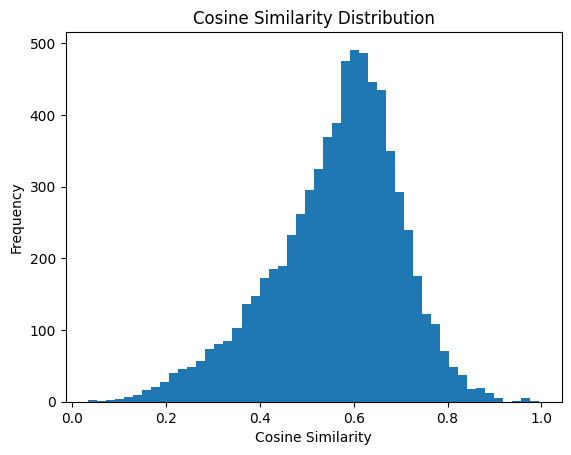

In [18]:
import matplotlib.pyplot as plt

joined_df['cosine_similarity'].hist(bins=50, grid=False)
plt.title('Cosine Similarity Distribution')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

###### [Go to top](#top)

<a id='3_6'></a>
### 3.6. Readability score

In [19]:
from textstat import flesch_reading_ease

In [20]:
joined_df['prompt_question_readability_score'] = joined_df['prompt_question'].apply(lambda x: flesch_reading_ease(x))
joined_df['summary_readability_score'] = joined_df['summary'].apply(lambda x: flesch_reading_ease(x))
joined_df['readability_score_ratio'] = joined_df['summary_readability_score'] / joined_df['prompt_question_readability_score']

joined_df.sample(3)

,prompt_question,prompt_title,prompt_text,summary,content,wording,prompt_question_tokenized,prompt_title_tokenized,prompt_text_tokenized,summary_tokenized,...,prompt_text_polarity_score,summary_polarity_score,polarity_score_ratio,prompt_text_subjectivity_score,summary_subjectivity_score,subjectivity_score_ratio,cosine_similarity,prompt_question_readability_score,summary_readability_score,readability_score_ratio
3165,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,The ancient Egypt system of government was str...,1.958298,-0.216445,"[In, complete, sentences, ,, summarize, the, s...","[Egyptian, Social, Structure]","[Egyptian, society, was, structured, like, a, ...","[The, ancient, Egypt, system, of, government, ...",...,0.206463,0.433333,2.098847,0.494048,0.500,1.012048,0.707223,53.88,90.09,1.672049
4862,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,it was ended because it lead people to justify...,-1.184871,-0.872720,"[Summarize, how, the, Third, Wave, developed, ...","[The, Third, Wave]","[Background, The, Third, Wave, experiment, too...","[it, was, ended, because, it, lead, people, to...",...,-0.004218,0.000000,-0.000000,0.359906,0.000,0.000000,0.287360,60.65,47.46,0.782523
3512,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,That egypt is an old country that is usually k...,-1.105528,-0.240368,"[In, complete, sentences, ,, summarize, the, s...","[Egyptian, Social, Structure]","[Egyptian, society, was, structured, like, a, ...","[That, egypt, is, an, old, country, that, is, ...",...,0.206463,0.116000,0.561845,0.494048,0.542,1.097060,0.487402,53.88,70.97,1.317186


###### [Go to top](#top)

<a id='3_7'></a>
### 3.7. Misspelling frequency

In [21]:
from spellchecker import SpellChecker
sc = SpellChecker()

In [22]:
def calculate_misspeling_percentage(word_list):

    misspelled = sc.unknown(word_list)
    percentage_of_misspelled = len(misspelled)/len(word_list)
    
    return percentage_of_misspelled

In [23]:
joined_df['summary_misspelled_words_percentage'] = joined_df['summary_tokenized'].apply(lambda x: calculate_misspeling_percentage(x))

In [24]:
joined_df.sample(3)

,prompt_question,prompt_title,prompt_text,summary,content,wording,prompt_question_tokenized,prompt_title_tokenized,prompt_text_tokenized,summary_tokenized,...,summary_polarity_score,polarity_score_ratio,prompt_text_subjectivity_score,summary_subjectivity_score,subjectivity_score_ratio,cosine_similarity,prompt_question_readability_score,summary_readability_score,readability_score_ratio,summary_misspelled_words_percentage
2867,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,The structure of ancient Egypts government con...,-0.910596,-0.081769,"[In, complete, sentences, ,, summarize, the, s...","[Egyptian, Social, Structure]","[Egyptian, society, was, structured, like, a, ...","[The, structure, of, ancient, Egypts, governme...",...,0.258333,1.251236,0.494048,0.416667,0.843373,0.689008,53.88,63.70,1.182257,0.057143
342,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...,"They must have a complex plan, they should exc...",-0.885374,-0.996015,"[Summarize, at, least, 3, elements, of, an, id...","[On, Tragedy]","[Chapter, 13, As, the, sequel, to, what, has, ...","[They, must, have, a, complex, plan, ,, they, ...",...,-0.105000,-9.201391,0.491573,0.448333,0.912037,0.494966,58.28,71.82,1.232327,0.000000
2747,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,Egyptian society had different social classes ...,0.376374,0.463619,"[In, complete, sentences, ,, summarize, the, s...","[Egyptian, Social, Structure]","[Egyptian, society, was, structured, like, a, ...","[Egyptian, society, had, different, social, cl...",...,0.106667,0.516639,0.494048,0.408333,0.826506,0.714528,53.88,59.33,1.101151,0.055556


###### [Go to top](#top)

<a id='3_8'></a>
### 3.8. Topic overlap

In [25]:
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')
lem=WordNetLemmatizer()

from gensim import corpora
from gensim.models import LdaModel
import re

[nltk_data] Downloading package punkt to /Users/duje/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/duje/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [26]:
def tokenize(text):
    
    tokens = pd.Series(text).apply(lambda x: word_tokenize(x))
    return tokens

def filter_stopwords(tokens):
    return [word for word in tokens if word not in stop and word.isalnum()]

def remove_stopwords(tokens):
    
    filtered_text = tokens.apply(filter_stopwords)
    return filtered_text

def remove_special_characters(tokens):
    
    special_characters = [".", ",", "!", "?", ":", ";", "'", '"', "(", ")", "[", "]", "{", "}"]
    filtered_text = tokens.apply(lambda x: [word for word in x if word not in special_characters])
    return filtered_text

def make_lowercase(tokens):
    
    lowercase_text = tokens.apply(lambda x: [word.lower() for word in x])
    return lowercase_text

def create_corpus(tokens):
    
    corpus = [word for sublist in tokens for word in sublist]
    return corpus

def lemmatize_and_wrap_in_list(corpus):
    
    infinitives = [[lem.lemmatize(w) for w in corpus]]
    return infinitives

def create_bow_corpus(dictionary, infinitives):
    
    bow_corpus = [dictionary.doc2bow(doc) for doc in infinitives]
    return bow_corpus

def create_lda_model(bow_corpus, num_topics, dictionary, num_passes = 15):
    
    lda_model = LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=num_passes)
    return lda_model

def extract_topics(lda_model, num_words = 5):
    
    topics = lda_model.print_topics(num_words=num_words)
    return topics

def get_topic_words(topics):
    
    topic_words = " ".join([" ".join(re.findall(r'"([^"]*)"', topic[1])) for topic in topics])
    return topic_words

In [27]:
def calculate_topic_overlap(prompt_question, prompt_text, summary):

    num_topics = 3
    
    #tokenize
    prompt_question_tokens = tokenize(prompt_question)
    prompt_text_tokens = tokenize(prompt_text)
    prompt_summary_tokens = tokenize(summary)
    
    #remove stopwords
    prompt_question_non_stopwords = remove_stopwords(prompt_question_tokens)
    prompt_text_non_stopwords = remove_stopwords(prompt_text_tokens)
    prompt_summary_non_stopwords = remove_stopwords(prompt_summary_tokens)
    
    #remove special characters
    prompt_question_non_stopwords = remove_special_characters(prompt_question_non_stopwords)
    prompt_text_non_stopwords = remove_special_characters(prompt_text_non_stopwords)
    prompt_summary_non_stopwords = remove_special_characters(prompt_summary_non_stopwords)  
    
    #lowercase
    prompt_question_non_stopwords = make_lowercase(prompt_question_non_stopwords)
    prompt_text_non_stopwords = make_lowercase(prompt_text_non_stopwords)
    prompt_summary_non_stopwords = make_lowercase(prompt_summary_non_stopwords)
    
    #flatten lists to create corpus
    prompt_combined_non_stopwords = prompt_question_non_stopwords + prompt_text_non_stopwords
    corpus_prompt = create_corpus(prompt_combined_non_stopwords)
    corpus_summary = create_corpus(prompt_summary_non_stopwords)
    
    #lemmatize and wrap in list for gensim (i.e. create list of lists as gensim expects)
    infinitives_prompt = lemmatize_and_wrap_in_list(corpus_prompt)
    infinitives_summary = lemmatize_and_wrap_in_list(corpus_summary)
    
    #create dictionary
    dictionary_prompt = corpora.Dictionary(infinitives_prompt)
    dictionary_summary = corpora.Dictionary(infinitives_summary)
    
    #create bag of words corpus
    bow_corpus_prompt = create_bow_corpus(dictionary_prompt, infinitives_prompt)
    bow_corpus_summary = create_bow_corpus(dictionary_summary, infinitives_summary)
    
    #create LDA model
    lda_model_prompt = create_lda_model(bow_corpus_prompt, num_topics, dictionary_prompt)
    lda_model_summary = create_lda_model(bow_corpus_summary, num_topics, dictionary_summary)
    
    #get topics
    topics_prompt = extract_topics(lda_model_prompt)
    topic_summary = extract_topics(lda_model_summary)
    
    #get words describing topics and calculate cosine similarity between them
    topics_prompt_words = get_topic_words(topics_prompt)
    topics_summary_words = get_topic_words(topic_summary)
    
    topic_overlap = calculate_cosine_similarity(topics_prompt_words, topics_summary_words)
    
    #return topics_prompt_words, topics_summary_words, topic_overlap
    return pd.Series([topics_prompt_words, topics_summary_words, topic_overlap])

In [28]:
joined_df[['topics_prompt_words', 'topics_summary_words', 'topic_overlap']] = joined_df.apply(lambda x: calculate_topic_overlap(x['prompt_question'], x['prompt_text'], x['summary']), axis=1)

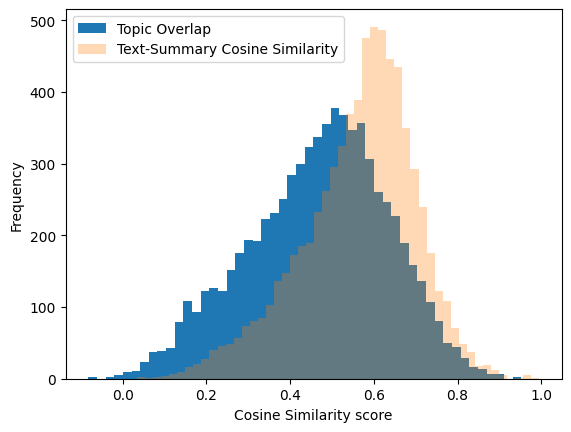

In [29]:
joined_df['topic_overlap'].hist(bins=50, grid=False)

joined_df['cosine_similarity'].hist(bins=50, grid=False, alpha=0.3)
plt.xlabel('Cosine Similarity score')
plt.ylabel('Frequency')
plt.legend(['Topic Overlap', 'Text-Summary Cosine Similarity'])

###### [Go to top](#top)

<a id='3_9'></a>
### 3.9. N-gram overlap

In [30]:
from nltk.util import ngrams
from collections import Counter

from word2number import w2n


In [31]:
def convert_words_to_numbers(text):
    words = text.split()
    converted_words = []

    for word in words:
        try:
            converted_word = str(w2n.word_to_num(word))
            converted_words.append(converted_word)
        except ValueError:  # word_to_num raises ValueError if it can't convert
            converted_words.append(word)

    converted_text = ' '.join(converted_words)
    return converted_text

In [32]:
def calculate_ngram_overlap(prompt_question, prompt_text, summary, top_n=20):
    # Tokenize
    prompt_question_tokens = tokenize(prompt_question)
    prompt_text_tokens = tokenize(prompt_text)
    prompt_summary_tokens = tokenize(summary)

    # Remove stopwords
    prompt_question_non_stopwords = remove_stopwords(prompt_question_tokens)
    prompt_text_non_stopwords = remove_stopwords(prompt_text_tokens)
    prompt_summary_non_stopwords = remove_stopwords(prompt_summary_tokens)

    # Remove special characters
    prompt_question_non_stopwords = remove_special_characters(prompt_question_non_stopwords)
    prompt_text_non_stopwords = remove_special_characters(prompt_text_non_stopwords)
    prompt_summary_non_stopwords = remove_special_characters(prompt_summary_non_stopwords)

    # Lowercase
    prompt_question_non_stopwords = make_lowercase(prompt_question_non_stopwords)
    prompt_text_non_stopwords = make_lowercase(prompt_text_non_stopwords)
    prompt_summary_non_stopwords = make_lowercase(prompt_summary_non_stopwords)

    # Flatten lists to create corpus
    prompt_combined_non_stopwords = prompt_question_non_stopwords + prompt_text_non_stopwords
    corpus_prompt = create_corpus(prompt_combined_non_stopwords)
    corpus_summary = create_corpus(prompt_summary_non_stopwords)

    # Convert numbers to text in the corpus (e.g., 1 -> one)
    corpus_prompt = [convert_words_to_numbers(text) for text in corpus_prompt]
    corpus_summary = [convert_words_to_numbers(text) for text in corpus_summary]

    # Create bigrams and trigrams, and calculate their frequency
    bigrams_prompt = ngrams(corpus_prompt, 2)
    trigrams_prompt = ngrams(corpus_prompt, 3)
    bigrams_summary = ngrams(corpus_summary, 2)
    trigrams_summary = ngrams(corpus_summary, 3)

    bigrams_prompt_list = [' '.join(bigram) for bigram in bigrams_prompt]
    trigrams_prompt_list = [' '.join(trigram) for trigram in trigrams_prompt]
    bigrams_summary_list = [' '.join(bigram) for bigram in bigrams_summary]
    trigrams_summary_list = [' '.join(trigram) for trigram in trigrams_summary]

    # Calculate the frequency of each bigram and trigram in both lists
    prompt_bigram_freq = Counter(bigrams_prompt_list)
    prompt_trigram_freq = Counter(trigrams_prompt_list)
    summary_bigram_freq = Counter(bigrams_summary_list)
    summary_trigram_freq = Counter(trigrams_summary_list)

    # Calculate the overlap between the two sets of bigrams and trigrams
    matching_bigrams = prompt_bigram_freq.keys() & summary_bigram_freq.keys()
    matching_trigrams = prompt_trigram_freq.keys() & summary_trigram_freq.keys()

    # Calculate the overlap ratios
    bigram_overlap_ratio = len(matching_bigrams) / len(prompt_bigram_freq)
    trigram_overlap_ratio = len(matching_trigrams) / len(prompt_trigram_freq)

    return pd.Series([bigram_overlap_ratio, trigram_overlap_ratio])


In [33]:
joined_df[['bigram_ratio', 'trigram_ratio']] = joined_df.apply(lambda x: calculate_ngram_overlap(x['prompt_question'], x['prompt_text'], x['summary']), axis=1)

###### [Go to top](#top)

<a id='3_10'></a>
### 3.10. Entity overlap

In [34]:
import spacy

# Load spaCy model for entity recognition
! python -m spacy download en_core_web_md
nlp = spacy.load("en_core_web_md")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 23.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: en-core-web-md
    Found existing installation: en-core-web-md 3.7.0
    Uninstalling en-core-web-md-3.7.0:
      Successfully uninstalled en-core-web-md-3.7.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [35]:
def extract_entities(text):
    
    # Process the text with spaCy
    doc = nlp(text)
    
    # Extract entities (e.g., persons, organizations, etc.)
    entities = [ent.text for ent in doc.ents]
    
    return entities

def calculate_entity_overlap(prompt_text, summary):
    
    #convert to lowercase
    prompt_text = prompt_text.lower()
    summary = summary.lower()
    
    # Extract entities from prompt_text and convert them into a set
    entities_prompt = set(extract_entities(prompt_text))
    
    # Count how many entities from entities_prompt are present in summary
    matching_entities_count = sum(1 for entity in entities_prompt if entity in summary)
    
    # Calculate the entity overlap ratio
    entity_overlap_ratio = matching_entities_count / len(entities_prompt)
    
    return pd.Series([entity_overlap_ratio])


In [36]:
joined_df['entity_overlap_ratio'] = joined_df.apply(lambda row: calculate_entity_overlap(row['prompt_text'], row['summary']), axis=1)

<a id='3_11'></a>
### 3.11. Transition words frequency ratio